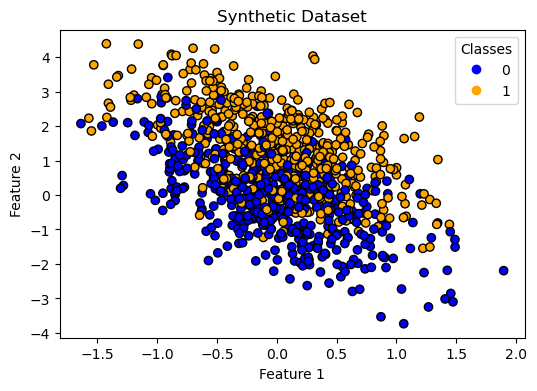

In [82]:
# Create 2 slightly overlapping blobs and plot them
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from typing import *

from sklearn.datasets import make_blobs

centers = [[0, 0], [1, 1]]
X, y = make_blobs(n_samples=1_000, centers=centers, random_state=0)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

fig, ax = plt.subplots(figsize=(6, 4))

cmap = ListedColormap(["blue", "orange"])
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor="black")

ax.set(title="Synthetic Dataset", xlabel="Feature 1", ylabel="Feature 2")
_ = ax.legend(*scatter.legend_elements(), title="Classes")

In [26]:
# Fit a logistic regression
from sklearn.linear_model import LogisticRegression

logistic_regression_multinomial = LogisticRegression().fit(X, y)

accuracy_multinomial = logistic_regression_multinomial.score(X, y)

In [ ]:
# Outlier generation function using the skew-based method

# (!) As a design choice, calculate variance vector over all datapoints, not just within the class
def unit_scale(v):
    return v/np.sum(v)


# # Generate an offset using the skew-based method and a certain level
# def generate_offset(X: np.array, alpha: float):
#     stdevs = np.std(X, axis=0)
#     v = unit_scale(stdevs)          # wait.. why do we normalize this? consider not normalizing this

#     d = X.shape[1]

#     zero_mean = np.zeros((d,))
#     identity_covariance = np.identity(d)
#     rng = np.random.default_rng()

#     rands = rng.multivariate_normal(mean = zero_mean, cov = identity_covariance)
#     noise = unit_scale(rands)       # scaling means that certain amount of change always, just in which directions -> ensures actual outliers

#     # print(rands)
#     return alpha * np.multiply(v, noise)

In [149]:
import numpy as np
from scipy.spatial.distance import cdist

def generate_artificial_outliers(X: np.array, 
                                 y: np.array,   # The original labels (unused)
                                 n_art: int,    # The number of artificial outliers to generate
                                 alpha: float,  # The multiplier
                                 epsilon: float, 
                                 mu: np.array = None, Sigma: np.array = None):
    """
    Generate artificial outliers by perturbing the original instances in X.

    Parameters:
        X (numpy.ndarray): The original instances (normal data points).
        nart (int): The number of artificial outliers to generate.
        mu (float): Mean of the normal distribution used for perturbation.
        sigma (float): Standard deviation of the normal distribution used for perturbation.
        alpha (float): Scaling factor for the perturbation.
        epsilon (float): Minimum distance to be considered an outlier.

    Returns:
        numpy.ndarray: A 2D array containing both original and artificial outliers.
    """
    n, d = X.shape

    # Default parameters: unit multivariate normal
    if mu is None:
        mu = np.zeros((d,))
    if Sigma is None:
        Sigma = np.identity(d)
    
    # Function for applying a perturbation using alpha and the given distribution
    def perturb(instance: np.array) -> np.array:
        noise = np.random.multivariate_normal(mu, Sigma)
        return instance + alpha * noise

    # Function for determining whether this is a sufficient outlier using epsilon
    def is_sufficient_outlier(possible_outlier: np.array) -> bool:
        distances = cdist([possible_outlier], X, metric='euclidean')
        dist = np.min(distances)        # distance to closest normal instance
        return dist >= epsilon

    # Container for artificial outliers
    ArtOuts = []
    
    # Step 1: Generate the first set of artificial outliers
    for i in range(n):
        # Step 2: Create artificial instance by perturbing this instance
        art_i = perturb(X[i])
        
        # Step 3: If this qualifies as an outlier, add
        if is_sufficient_outlier(art_i):
            ArtOuts.append(art_i)
    
    # Step 4a: if we already have enough, randomly sample n_art from these
    if len(ArtOuts) >= n_art:
        row_indices = np.random.choice(len(ArtOuts), size = n_art, replace = False)
        X_art = np.array(ArtOuts)[row_indices]
    
    # Step 4b: if we don't have enough, repeat the process atop these artificial outliers
    else:
        while len(ArtOuts) < n_art:
            # Randomly sample an existing artificial outlier
            out_i = ArtOuts[np.random.randint(0, len(ArtOuts))]

            # Perturb
            art_i = perturb(out_i)

            # Add if valid
            if is_sufficient_outlier(art_i):
                ArtOuts.append(art_i)

        X_art = np.array(ArtOuts)

    # Set the labels
    y_art = np.ones((n_art,))
    
    # Return the original data along with the artificial outliers
    return (X_art, y_art)

# # Generate n_art outliers with the given alpha based on the given dataset
# def generate_outliers(X: np.array, y: np.array, n_art: int, alpha: float) -> Tuple[np.array, np.array]:
#     # Get the shape
#     n, d = X.shape

#     # Generate a d-dimensional vecotr of normally distributed random variables that are scaled so that entries sum to 1
#     def generate_noise():
#         zero_mean = np.zeros((d,))
#         identity_covariance = np.identity(d)
#         rng = np.random.default_rng()
#         rands = rng.multivariate_normal(mean = zero_mean, cov = identity_covariance)
#         noise = unit_scale(rands)   
#         return noise

#     # Compute the v vector for the given X data. 
#     # (!) As a design choice, calculate variance vector over all datapoints, not just within the class
#     stdevs = np.std(X, axis=0)
#     v = unit_scale(stdevs)          # wait.. why do we normalize this? consider not normalizing this

#     # Initialize the generated outlier arrays 
#     X_art = np.empty((n_art, d))
#     y_art = np.empty((n_art,))

#     for i in range(n_art):
#         # Sample a random index j from the dataset X, y (i.e. random instance)
#         j = np.random.randint(0, X.shape[0])

#         # Set the label to be the same
#         y_art[i] = y[j]

#         # Set the features to be those of an offset with the genreated offset
#         noise = generate_noise()
#         offset = alpha * np.multiply(v, noise)
#         X_art[i] = X[j] + offset

#     return X_art, y_art

In [168]:
# epsilon is the minimum
# alpha is how wild we are with it
# probably makes sense to vary alpha only, if we do it at all? hard to tell ahead of time though: scale both up accordingly?
X_art, y_art = generate_artificial_outliers(X, y, n_art = 100, alpha = 0.3, epsilon = 0.1)

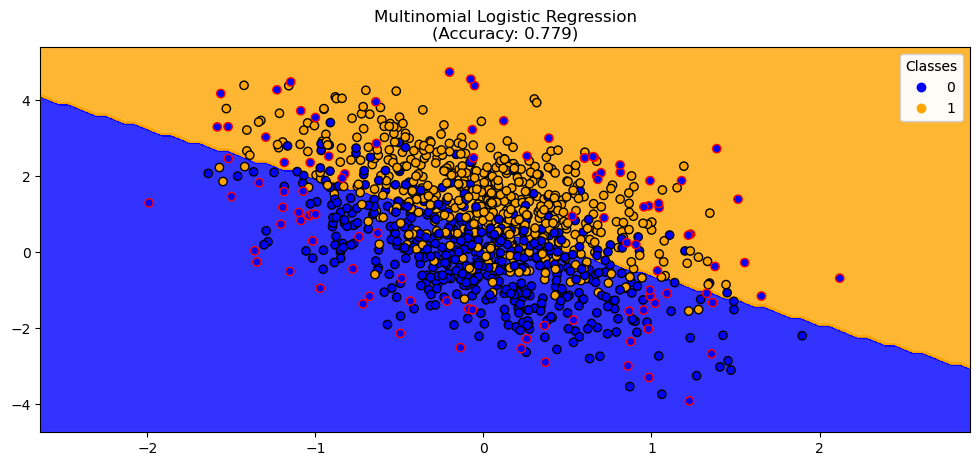

In [169]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax1 = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey=True)

for model, title, ax in [
    (
        logistic_regression_multinomial,
        f"Multinomial Logistic Regression\n(Accuracy: {accuracy_multinomial:.3f})",
        ax1,
    )
]:
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        ax=ax,
        response_method="predict",
        alpha=0.8,
        cmap=cmap
    )
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor="black")

    ax1.scatter(X_art[:, 0], X_art[:, 1], c=y_art, cmap=cmap, edgecolor="red")      # Plot the artificial points

    legend = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend)
    ax.set_title(title)